# Выбор локации для скважины

Допустим, мы работаем в добывающей компании. Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**: 
Данные геологоразведки трёх регионов находятся в файлах: 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:** 
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Загрузим данные и посмотрим на предварительную информацию о датасетах

In [1]:
#установки
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
# Импорт стандартных библиотек
import pandas as pd
import numpy as np

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек для машинного обучения и обработки данных
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.linear_model import  Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor

# Импорт библиотек для анализа данных
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik

Напишем функцию для того, что бы посмотреть всю предварительную информацию о датасетах: выведем первые строки, общую информацию, наличие пропусков и дубликатов.

In [4]:
def analyze_datasets(datasets):
    for i, df in enumerate(datasets):
        # Вывод первых строк
        print(f"First rows of dataset {i}:")
        print(df.head())
        print("\n")
        
        # Вывод информации о датасете
        print(f"Info of dataset {i}:")
        print(df.info())
        print("\n")
        
        # Проверка наличия пропусков
        print(f"Missing values in dataset {i}:")
        print(df.isnull().sum())
        print("\n")
        
        # Проверка наличия дубликатов
        print(f"Duplicate rows in dataset {i}:")
        print(df.duplicated().sum())
        print("\n")

# Список загруженных датасетов
datasets = [data_0, data_1, data_2]

# Запуск функции для анализа
analyze_datasets(datasets)

First rows of dataset 0:
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


Info of dataset 0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Missing values in dataset 0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Duplicate rows in dataset 0:
0


First rows of dataset 1:
      id         f0         f1        f2

Исходя из полученных данных, можно заключить, что данные наших датасетов в порядке. Не обнаружено явных дубликатов и пропусков. Типы данных каждого столбца соответствуют содержимому. Названия столбцов корректные

### Проверка дубликатов

Далее проверим наличие неявных дубликатов

In [5]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_0
duplicate_rows_0 = data_0.duplicated(subset=['f0', 'f1', 'f2', 'product'], keep=False)

In [6]:
data_0[duplicate_rows_0]

,id,f0,f1,f2,product


In [7]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_1
duplicate_rows_1 = data_1.duplicated(subset=['f0', 'f1', 'f2', 'product'], keep=False)

In [8]:
data_1[duplicate_rows_1]

,id,f0,f1,f2,product


In [9]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_2
duplicate_rows_2 = data_2.duplicated(subset=['f0', 'f1', 'f2', 'product'], keep=False)

In [10]:
data_2[duplicate_rows_2]

,id,f0,f1,f2,product


In [11]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_0
duplicate_rows_0_1 = data_0.duplicated(subset=['f0', 'f1', 'f2'], keep=False)

In [12]:
data_0[duplicate_rows_0_1]

,id,f0,f1,f2,product


In [13]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_1
duplicate_rows_1_1 = data_1.duplicated(subset=['f0', 'f1', 'f2'], keep=False)

In [14]:
data_1[duplicate_rows_1_1]

,id,f0,f1,f2,product


In [15]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_1
duplicate_rows_2_1 = data_2.duplicated(subset=['f0', 'f1', 'f2'], keep=False)

In [16]:
data_2[duplicate_rows_2_1]

,id,f0,f1,f2,product


Посмотрим насколько уникальные у нас id

In [17]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_0
duplicate_rows_0_2 = data_0.duplicated(subset=['id'], keep=False)

In [18]:
data_2[duplicate_rows_0_2]

,id,f0,f1,f2,product
931,moX6g,1.410073,1.129001,1.802743,90.884547
1364,26QRS,-1.921383,2.634151,2.771480,163.472295
1949,qdv7b,-2.259978,3.561475,7.208034,189.898277
3389,CELfv,-0.685541,-0.308214,-2.220209,136.993204
7530,8fP5H,-1.729697,-2.592517,2.757510,37.550380
16633,sCQ0l,2.379051,-1.350622,5.592104,82.042281
21426,uKn4N,1.426744,0.387084,-2.638249,15.500533
41724,BnxVN,-3.065122,1.522308,4.890901,126.815185
42529,eqKXv,-0.374419,1.187837,7.940085,135.875371
51970,bev1W,-0.400736,0.694304,-0.291779,97.533822


In [19]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_1
duplicate_rows_1_2 = data_1.duplicated(subset=['id'], keep=False)

In [20]:
data_1[duplicate_rows_1_2]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [21]:
# Проверим на дубликаты по выбранной комбинации столбцов для data_2
duplicate_rows_2_2 = data_2.duplicated(subset=['id'], keep=False)

In [22]:
data_2[duplicate_rows_2_2]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Видим, что у нескольких записей id повторяются. Удалим их

In [23]:
# Удаляем дубликаты в столбце 'id' для каждого датасета
data_0 = data_0.drop_duplicates(subset='id')
data_1 = data_1.drop_duplicates(subset='id')
data_2 = data_2.drop_duplicates(subset='id')

# Проверим, сколько строк осталось после удаления дубликатов
print(f"Размер data_0 после удаления дубликатов: {data_0.shape}")
print(f"Размер data_1 после удаления дубликатов: {data_1.shape}")
print(f"Размер data_2 после удаления дубликатов: {data_2.shape}")

Размер data_0 после удаления дубликатов: (99990, 5)
Размер data_1 после удаления дубликатов: (99996, 5)
Размер data_2 после удаления дубликатов: (99996, 5)


Удалили от 4 до 10 записей из каждого датасета

### Статистический анализ данных 

Далее проведем исследовательский анализ данных 

In [24]:
def statistic_datasets(datasets):
    for i, df in enumerate(datasets):
        # выведем данные статистики
        print(f"Statistical analysis {i}:")
        print(df.describe())
        print("\n")
        
#предоставим список загруженных датасетов
datasets = [data_0, data_1, data_2]

# запустим функцию для анализа
statistic_datasets(datasets)

Statistical analysis 0:
                 f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500454      0.250141      2.502629     92.499684
std        0.871844      0.504430      3.248149     44.288304
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072572     -0.200877      0.287784     56.497069
50%        0.502405      0.250252      2.515969     91.847928
75%        1.073626      0.700640      4.715035    128.563699
max        2.362331      1.343769     16.003790    185.364347


Statistical analysis 1:
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141209     -4.796608      2.494501     68.823916
std        8.965815      5.119906      1.703579     45.944663
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298551     -8.267985      1.000021     26.953261
50%        1.153055 

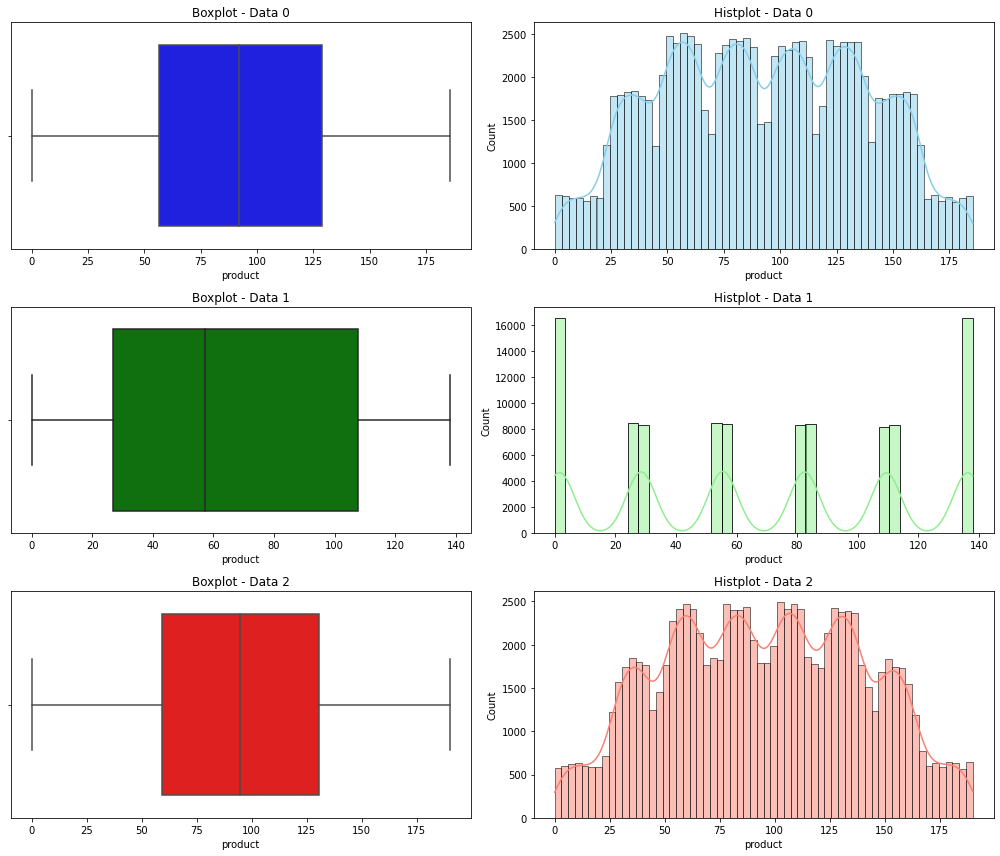

In [25]:
# Создаем фигуру и оси
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Data 0
sns.boxplot(data=data_0, x='product', ax=axes[0, 0], color='blue')
sns.histplot(data=data_0, x='product', kde=True, ax=axes[0, 1], color='skyblue')

# Data 1
sns.boxplot(data=data_1, x='product', ax=axes[1, 0], color='green')
sns.histplot(data=data_1, x='product', kde=True, ax=axes[1, 1], color='lightgreen')

# Data 2
sns.boxplot(data=data_2, x='product', ax=axes[2, 0], color='red')
sns.histplot(data=data_2, x='product', kde=True, ax=axes[2, 1], color='salmon')

# Настроим графики
axes[0, 0].set_title('Boxplot - Data 0')
axes[0, 1].set_title('Histplot - Data 0')
axes[1, 0].set_title('Boxplot - Data 1')
axes[1, 1].set_title('Histplot - Data 1')
axes[2, 0].set_title('Boxplot - Data 2')
axes[2, 1].set_title('Histplot - Data 2')

plt.tight_layout()
plt.show()

Рассмотрим статистические результаты. Тут нас интересуют только данные по объему запаса в скважине 'product'. Для 0 и 2 региона данные по среднему значению запаса нефти близки, однако в 1 регионе ее значительно меньше. Средний запас в 0 региона составляет 92.5 тыс баррелей, в 1-ом - 68.82, в 3-ем - 95 тыс баррелей. Стандартное отклоненение для всех 3-х регионов составляют ок 44-45 тыс баррелей, что значительно. Максимальный объем нефти в 0 регионе сотавил - 185.36, в 1-ом - 137.95, в 3-ем - 190.03 тыс баррелей. Минимальный объем составил для всех регионов равен 0. Распределение данных для 0 и 2 регионов очень похожи, чего не скажешь о регионе 1.

### Корреляционный анализ 

Далее проведем корреляционный анализ

In [26]:
#удалим столбец id из данных
data0 = data_0.drop(['id'], axis=1)
data1 = data_1.drop(['id'], axis=1)
data2 = data_2.drop(['id'], axis=1)

In [27]:
#укажем список непрерывных признаков
interval_cols = ['f0', 'f1', 'f2', 'product']
# Вычислим матрицы корреляций для каждого набора данных
phik_matrix_0 = data0.phik_matrix(interval_cols=interval_cols)
phik_matrix_1 = data1.phik_matrix(interval_cols=interval_cols)
phik_matrix_2 = data2.phik_matrix(interval_cols=interval_cols)
# Отобразим матрицы корреляций
print("Матрица корреляций для data_0:")
print(phik_matrix_0)

print("\nМатрица корреляций для data_1:")
print(phik_matrix_1)

print("\nМатрица корреляций для data_2:")
print(phik_matrix_2)

Матрица корреляций для data_0:
               f0        f1        f2   product
f0       1.000000  0.762181  0.000000  0.215523
f1       0.762181  1.000000  0.000000  0.253534
f2       0.000000  0.000000  1.000000  0.475867
product  0.215523  0.253534  0.475867  1.000000

Матрица корреляций для data_1:
               f0        f1        f2   product
f0       1.000000  0.196075  0.000000  0.628477
f1       0.196075  1.000000  0.000000  0.185948
f2       0.000000  0.000000  1.000000  0.978935
product  0.628477  0.185948  0.978935  1.000000

Матрица корреляций для data_2:
              f0        f1        f2   product
f0       1.00000  0.000000  0.000000  0.201070
f1       0.00000  1.000000  0.000000  0.220992
f2       0.00000  0.000000  1.000000  0.443282
product  0.20107  0.220992  0.443282  1.000000


Матрица корреляций для data_0:

Матрица корреляций для data_1:

Матрица корреляций для data_2:


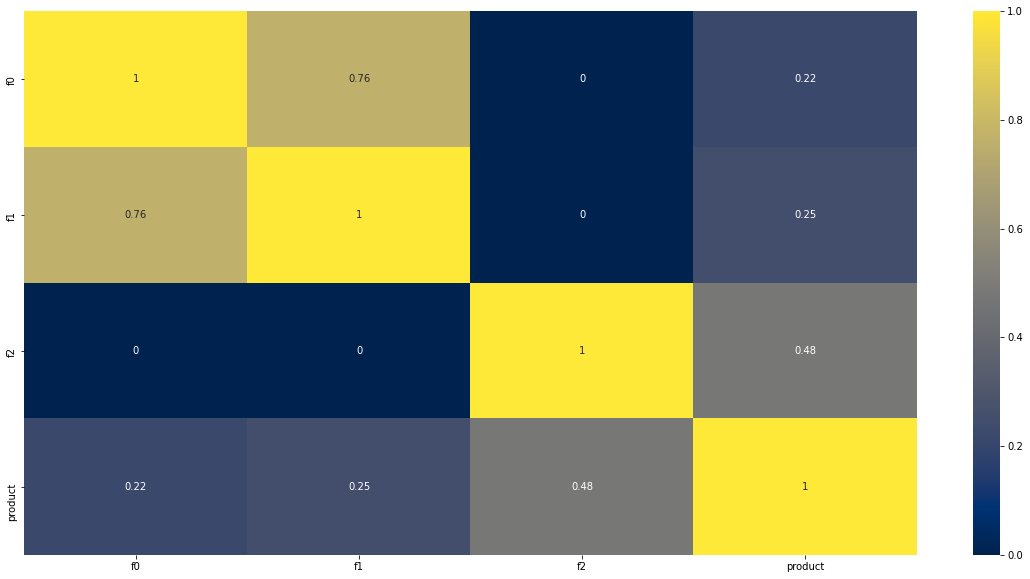

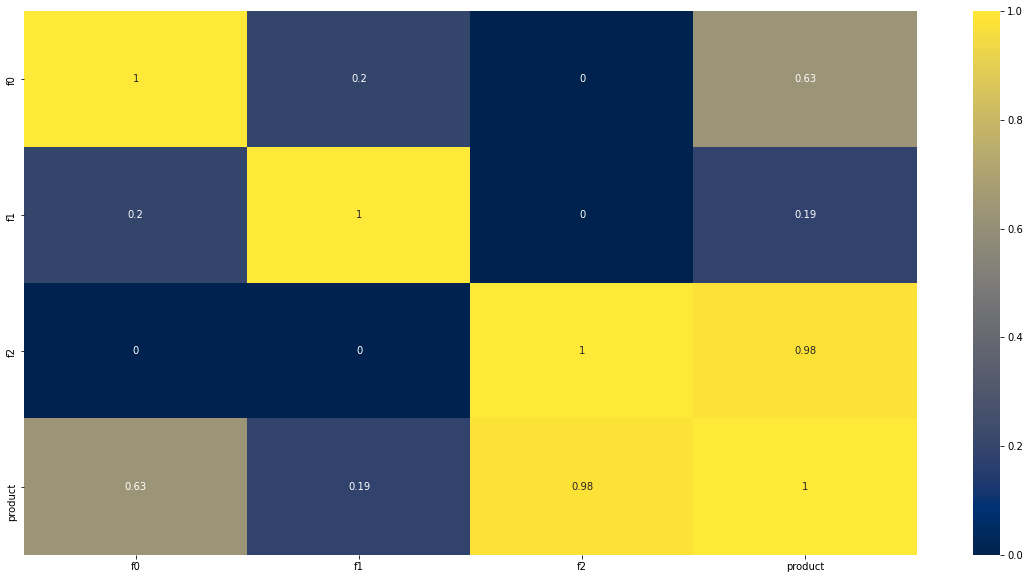

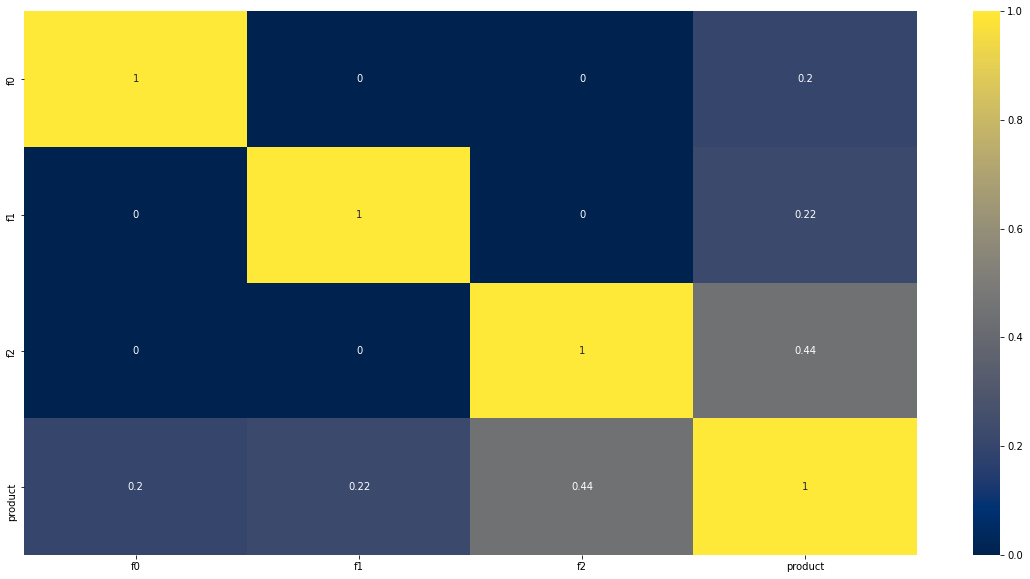

In [28]:
#визуализируем полученные матрицы
plt.figure(figsize=(20,10))
print("Матрица корреляций для data_0:")
sns.heatmap(data0.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

plt.figure(figsize=(20,10))
print("\nМатрица корреляций для data_1:")
sns.heatmap(data1.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

plt.figure(figsize=(20,10))
print("\nМатрица корреляций для data_2:")
sns.heatmap(data2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

Исходя из полученной матрицы корреляции Phik, можно отметить следующее: 1) для региона 0, объем запасов нефти коррелирует с f2(0.48), затем с f1(0.25) и f0(0.22). Относительно высокую корреляцию между собой имеют признаки f0 и f1 (0.76) 2) для региона 1, объем запасов нефти сильно коррелирует с f2(0.98), что говорит о том, что f2 является самым значимым признаком для предсказания объема запасов нефти в этом регионе. Затем с f0(0.63) и f1(0.19). 3)  для региона 2, объем запасов нефти коррелирует с f2(0.44), затем с f1(0.22) и f0(0.2).

Расчёт VIF помогает определить, насколько степень корреляции между признаками может повлиять на устойчивость модели. Значения VIF выше 10 (или иногда 5) указывают на значительную мультиколлинеарность.

In [29]:
# добавим константы для расчета VIF
X = add_constant(data0)

In [30]:
#вычислим VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [31]:
vif_data

,feature,VIF
0,const,6.861392
1,f0,1.248692
2,f1,1.276588
3,f2,1.323630
4,product,1.380607


Все значения VIF значительно ниже порога 10 (или 5), что указывает на отсутствие значительной мультиколлинеарности. Значения VIF ниже 10 означают, что корреляция между признаками не является проблемой для устойчивости модели в данном регионе.

In [32]:
# добавим константы для расчета VIF
X = add_constant(data1)
#вычислим VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [33]:
vif_data

,feature,VIF
0,const,7.561359
1,f0,3.163188
2,f1,1.049804
3,f2,2660.123168
4,product,2662.639020


Значения VIF для f2 и product крайне высоки (приблизительно 2660), что указывает на сильную зависимость между этими признаками. Это согласуется с высокой корреляцией между f2 и product, выявленной ранее.

In [34]:
# добавим константы для расчета VIF
X = add_constant(data2)
#вычислим VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [35]:
vif_data

,feature,VIF
0,const,5.571730
1,f0,1.000004
2,f1,1.000003
3,f2,1.248126
4,product,1.248132


Все значения VIF значительно ниже порога 10 (или 5), что указывает на отсутствие значительной мультиколлинеарности. Значения VIF ниже 10 означают, что корреляция между признаками не является проблемой для устойчивости модели в данном регионе.

## Обучение и проверка модели

###  Обучение и проверка модели для региона 0

напишем наш паплайн

In [36]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
#разделим наши данные на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(
    data0.drop(['product'], axis=1),
    data0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
X_train.shape, X_val.shape

((74992, 3), (24998, 3))

Целевая переменная у нас - непрерывная величина, поэтому отдельно кодировать ее не требуется. В качестве модели будем рассматривать модель линейной регрессии

Так, как у нас нет категориальных данных, то и кодирование не требуется. Значит займемся только масштабированием с использованием MinMaxScaler и StandardScaler

In [37]:
num_columns = ['f0', 'f1', 'f2']

In [38]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Как уже говорила выше, поскольку у нас целевая переменная - непрерывная величина, то мы будем в качестве модели рассматривать модель линейной регрессии. При варьировании параметров линейной регрессии мы попробуем рассмотреть 3 метода линейной регрессии: Ridge, Lasso и ElasticNet (каждого со своими параметрами). Это методы линейной регрессии, которые помогают улучшить обобщающую способность моделей и управлять проблемами, связанными с переобучением и многократной коллинеарностью.

In [40]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', Ridge())
])
param_grid = [
    {
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'saga', 'lsqr'],
        'model__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__tol': [1e-4, 1e-3, 1e-2],
        'model__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [ElasticNet()],
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__l1_ratio': [0.2, 0.5, 0.7, 1.0],
        'model__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]


In [41]:
# Инициализация GridSearchCV
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error' ,
    n_jobs=-1
)

# Обучение модели
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['f0',
                                                                          'f1',
                                                                          'f2'])])),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid=[{'model': [Ridge(alpha=10, solver='saga')],
                          'model__alpha': [0.01, 0.1, 1, 10, 100],
                          'model__fit_intercept': [True, False],
                          'model__solver': ['auto', 'saga', 'lsqr'...
                          'model__alpha': [0.01, 0.1, 1, 10, 100],
     

In [42]:
print('Метрика MSE для лучшей модели:\n', -grid_search.best_score_)
print('Метрика RMSE для лучшей модели:\n', np.sqrt(-grid_search.best_score_))
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

Метрика MSE для лучшей модели:
 1421.0964655164419
Метрика RMSE для лучшей модели:
 37.697433142276964

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=10, solver='saga'))])


Таким образом, лучшей моделью оказалась модель линейной регрессии Ridge со следующими параметрами: alpha=0.01, solver='saga'

In [43]:
# проверим работу модели на валидационной выборке
# рассчитаем прогноз на валидационных данных
y_val_pred = grid_search.predict(X_val)
print(f'Метрика MSE на валидационной выборке: {mean_squared_error(y_val, y_val_pred)}')
print(f'Метрика RSME на валидационной выборке: {np.sqrt(mean_squared_error(y_val, y_val_pred))}')
print(f'Средний запас предсказанного сырья: {np.mean(y_val_pred)}')

Метрика MSE на валидационной выборке: 1420.1669830249346
Метрика RSME на валидационной выборке: 37.685102932391395
Средний запас предсказанного сырья: 92.60982612924983


MSE и RMSE дают представление о том, насколько хорошо модель предсказывает значения. Низкие значения MSE и RMSE указывают на хорошее качество модели. В данном случае, RMSE равен 37.76, что означает, что средняя ошибка предсказания модели составляет примерно 37.76 единиц от истинного значения. 

Далее сравним нашу лучшую модель с константной моделью

In [44]:
#инициализируем DummyRegressor со стратегией 'mean'
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

#предскажем константную модель на валидацционных данных
y_dummy_pred = dummy_model.predict(X_val)

#оценим качество константной модели
print(f'Метрика MSE на валидационной выборке: {mean_squared_error(y_val, y_dummy_pred )}')
print(f'Метрика RSME на валидационной выборке: {np.sqrt(mean_squared_error(y_val, y_dummy_pred ))}')
print(f'Средний запас предсказанного сырья: {np.mean(y_dummy_pred )}')

Метрика MSE на валидационной выборке: 1957.626967248855
Метрика RSME на валидационной выборке: 44.24507845228501
Средний запас предсказанного сырья: 92.53665796438528


Наша лучшая модель значительно превосходит константную модель, что подтверждает, что все усилия по созданию новых признаков, тюнингу и кросс-валидации оправданы. Это также подтверждает, что наша модель вносит существенный вклад в улучшение качества предсказаний по сравнению с простым подходом.

Далее проведем анализ остатков.

In [45]:
# Предсказанные значения на тестовой выборке
residuals = y_val - y_val_pred

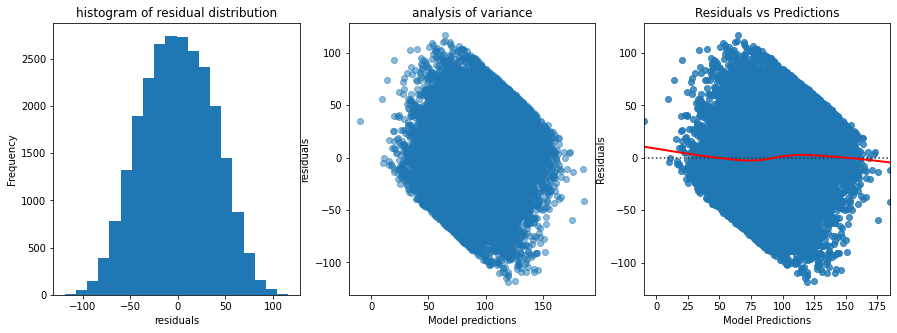

In [46]:
#Построим графики по количественным признакам - гистограмму частотности
#распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15, 5))

axes[0].hist(residuals, bins = 20)
axes[0].set_title('histogram of residual distribution')
axes[0].set_xlabel('residuals')
axes[0].set_ylabel('Frequency')

axes[1].scatter(y_val_pred, residuals, alpha = 0.5)
axes[1].set_xlabel('Model predictions')
axes[1].set_ylabel('residuals')
axes[1].set_title('analysis of variance')

# sns.residplot для оценки распределения остатков и их гомоскедастичности
sns.residplot(x=y_val_pred, y=residuals, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
axes[2].set_title('Residuals vs Predictions')
axes[2].set_xlabel('Model Predictions')
axes[2].set_ylabel('Residuals')

plt.show()

Остатки модели не только показывают разницу между предсказанным и истинным значениями. Они также отражают закономерности, которые позволяют судить о качестве модели. Анализ остатков проверяет не решения модели, а то, насколько хорошо она замечает взаимосвязи между признаками. Если она не справляется с этим, то уже не важно, близки ли её предсказания к исходным значениям. Модель будет работать нестабильно.

Если посмотрим на график распределения остатков (график слева), то он показывает симметричное распределение, это может свидетельствовать о том, что модель в целом хорошо справляется с предсказаниями.
Если посмотрим на диаграмму рассеяния (2 графика справа) остатков в зависимости от прогнозных значений модели, то отметим, что линия, полученная с помощью lowess, практически прямая, но с небольшим искривлением, это указывает на то, что остатки модели в целом распределены нормально, но возможны незначительные отклонения в зависимости от предсказанных значений. Небольшое искривление линии может свидетельствовать о возможных нелинейных отношениях, которые модель не полностью улавливает. В таком случае, модель может слегка недооценивать или переоценивать значения в определенных диапазонах предсказаний.

Так как у нас 3 похожих датасета, напишем функцию для анализа, что б упростить вычисления + сделаем так, что б получить таблицы  валидационной выборки сразу с реальными и предсказанными данными по выходу продукта (нефти). 

In [47]:
def evaluate_model(data, target_column, random_state=42, test_size=0.25):
    # разделим наши данные на обучающую и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(
        data.drop([target_column], axis=1),
        data[target_column],
        test_size=test_size, 
        random_state=random_state
    )
    
    # определим наши признаки
    num_columns = X_train.columns.tolist()
    
    #создадим  пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        [
            ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )
    
    # создадим итоговый пайплайн
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', Ridge())
    ])
    
    param_grid = [
        {
            'model': [Ridge()],
            'model__alpha': [0.01, 0.1, 1, 10, 100],
            'model__solver': ['auto', 'saga', 'lsqr'],
            'model__fit_intercept': [True, False],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        },
        {
            'model': [Lasso()],
            'model__alpha': [0.01, 0.1, 1, 10, 100],
            'model__tol': [1e-4, 1e-3, 1e-2],
            'model__fit_intercept': [True, False],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        },
        {
            'model': [ElasticNet()],
            'model__alpha': [0.01, 0.1, 1, 10, 100],
            'model__l1_ratio': [0.2, 0.5, 0.7, 1.0],
            'model__fit_intercept': [True, False],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        }
    ]
    
    # иницилизируем  GridSearchCV
    grid_search = GridSearchCV(
        pipe_final,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # обучим нашу модель
    grid_search.fit(X_train, y_train)
    print('Метрика MSE для лучшей модели:\n', -grid_search.best_score_)
    print('Метрика RMSE для лучшей модели:\n', np.sqrt(-grid_search.best_score_))
    print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 
    
    # оценим наши метрики на валидационной выборке
    y_val_pred = grid_search.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    avg_pred = np.mean(y_val_pred)
    
    print('Метрика MSE для валидационной модели:', mse)
    print('Метрика RMSE для валидационной модели:', rmse)
    print('Средний запас предсказанного сырья:', avg_pred)
    
    #добавим наши предсказанные значения сразу в валидационную выборку в виде отдельного столбца
    X_val['true_product'] = y_val.values
    X_val['predicted_product'] = y_val_pred
    
    #вычислим метрики для дамми модели
    dummy_model = DummyRegressor(strategy='mean')
    dummy_model.fit(X_train, y_train)
    y_dummy_pred = dummy_model.predict(X_val)
    dummy_mse = mean_squared_error(y_val, y_dummy_pred)
    dummy_rmse = np.sqrt(dummy_mse)
    
    print('\nКонстантная модель:')
    print('Метрика MSE на валидационной выборке:', dummy_mse)
    print('Метрика RMSE на валидационной выборке:', dummy_rmse)
    
    # Анализ остатков
    residuals = y_val - y_val_pred
    
    # построим графики остатков
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    axes[0].hist(residuals, bins=20)
    axes[0].set_title('Histogram of Residual Distribution')
    axes[0].set_xlabel('Residuals')
    axes[0].set_ylabel('Frequency')
    
    axes[1].scatter(y_val_pred, residuals, alpha=0.5)
    axes[1].set_xlabel('Model Predictions')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Analysis of Variance')
    
    sns.residplot(x=y_val_pred, y=residuals, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
    axes[2].set_title('Residuals vs Predictions')
    axes[2].set_xlabel('Model Predictions')
    axes[2].set_ylabel('Residuals')
    
    plt.show()
    
    # Возвращаем валидационную выборку, метрики RMSE и дамми-модель
    return X_val, rmse, dummy_rmse, residuals

Метрика MSE для лучшей модели:
 1421.0799714710324
Метрика RMSE для лучшей модели:
 37.697214372829094

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=1, solver='saga'))])
Метрика MSE для валидационной модели: 1420.1638345805554
Метрика RMSE для валидационной модели: 37.685061159304965
Средний запас предсказанного сырья: 92.60982414166759

Константная модель:
Метрика MSE на валидационной выборке: 1957.626967248855
Метрика RMSE на валидационной выборке: 44.24507845228501


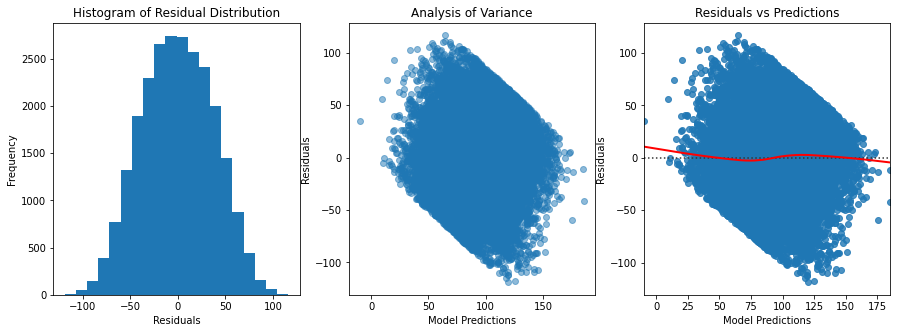

In [48]:
#посмотрим/проверим еще раз данные для 0 региона
X_val_0, rmse_0, dummy_rmse_0, residuals_0 = evaluate_model(data0, 'product')

In [49]:
#выведем на экран первые 5 строк валидационной выборки для региона 0 с добавленными предсказаннными значениями
X_val_0.head()

,f0,f1,f2,true_product,predicted_product
33966,1.760123,0.602091,7.850248,119.813252,127.502839
22854,0.948101,-0.601353,4.055264,133.296862,116.465669
19449,-0.721709,0.577912,-0.134307,25.310435,66.034711
9733,-0.084550,0.907580,-2.972129,65.422491,45.000351
7129,0.272074,0.818032,8.694180,140.851476,124.550101


###  Обучение и проверка модели для региона 1

Далее применим нашу функцию к датасету региона 1:

Метрика MSE для лучшей модели:
 0.7913973568604787
Метрика RMSE для лучшей модели:
 0.8896051690837227

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=1, solver='saga'))])
Метрика MSE для валидационной модели: 0.7971099481702641
Метрика RMSE для валидационной модели: 0.8928101411667904
Средний запас предсказанного сырья: 68.57708560865926

Константная модель:
Метрика MSE на валидационной выборке: 2112.7639983499243
Метрика RMSE на валидационной выборке: 45.96481261084314


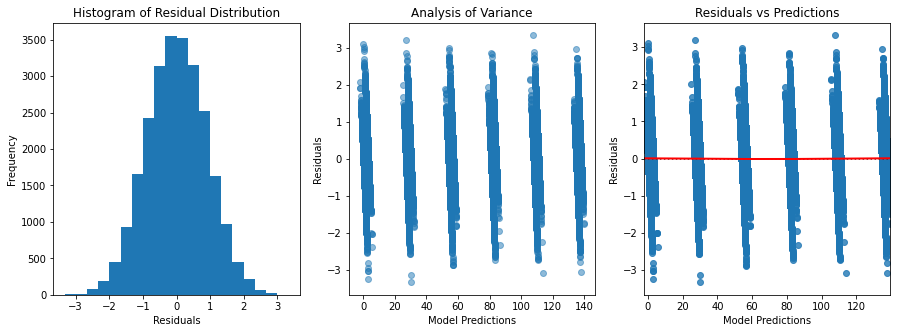

In [50]:
#применим функцию к 'data1'... региону 1
X_val_1, rmse_1, dummy_rmse_1, residuals_1 = evaluate_model(data1, 'product')

In [51]:
#выведем на экран первые 5 строк валидационной выборки для региона 1 с добавленными предсказаннными значениями
X_val_1.head()

,f0,f1,f2,true_product,predicted_product
33968,0.518707,-5.983575,0.001335,0.000000,1.742545
24612,5.588148,-2.187963,5.003146,134.766305,135.734676
42678,18.826929,-2.119254,4.993071,134.766305,133.540122
9732,-0.353690,-10.003708,0.998885,30.132364,28.837782
7129,-9.755378,-2.236383,5.006190,137.945408,138.044840


Таким образом, для рассчета продукта региона 1, лучшей моделью оказалась модель линейной регрессии Ridge со следующими параметрами: alpha=0.01. Низкие значения MSE и RMSE указывают на хорошее качество модели. В данном случае, RMSE равен 0.89, что означает, что средняя ошибка предсказания модели составляет примерно 0.89 единиц от истинного значения. Данная метрика значительно ниже, чем для региона 0, возможно это связано с тем, у целевой переменной и признака f2 очень высокая корреляция. Наша лучшая модель значительно превосходит константную модель, что подтверждает, что все усилия по созданию новых признаков, тюнингу и кросс-валидации оправданы. Это также подтверждает, что наша модель вносит существенный вклад в улучшение качества предсказаний по сравнению с простым подходом. 
При анализе остатков, можно отметить, что график распределения остатков (график слева) показывает симметричное распределение, это может свидетельствовать о том, что модель в целом хорошо справляется с предсказаниями. Если посмотрим на диаграмму рассеяния (2 графика справа) остатков в зависимости от прогнозных значений модели, то отметим, что линия, полученная с помощью lowess, практически прямая, но с небольшим искривлением, это указывает на то, что остатки модели в целом распределены нормально, но возможны незначительные отклонения в зависимости от предсказанных значений. Небольшое искривление линии может свидетельствовать о возможных нелинейных отношениях, которые модель не полностью улавливает. В таком случае, модель может слегка недооценивать или переоценивать значения в определенных диапазонах предсказаний. Однако, сам характер графика необычный.

###  Обучение и проверка модели для региона 2

Метрика MSE для лучшей модели:
 1603.8348692748714
Метрика RMSE для лучшей модели:
 40.047907177215535

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Lasso(alpha=0.1, tol=0.01))])
Метрика MSE для валидационной модели: 1606.3955016073182
Метрика RMSE для валидационной модели: 40.079864041776865
Средний запас предсказанного сырья: 94.93524065660043

Константная модель:
Метрика MSE на валидационной выборке: 1995.353466724719
Метрика RMSE на валидационной выборке: 44.66937952025659


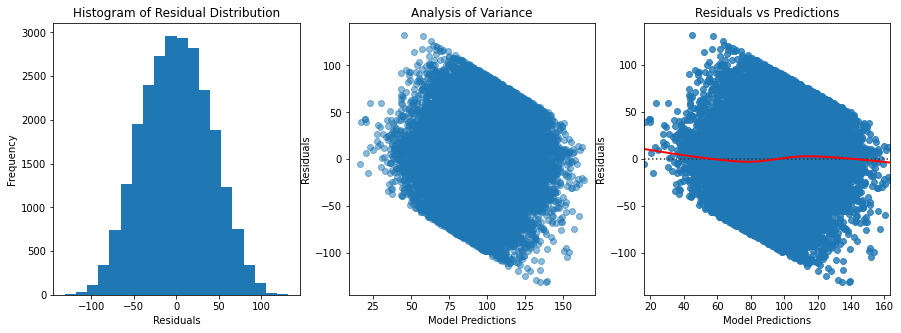

In [52]:
#применим функцию к 'data2'... региону 2
X_val_2, rmse_2, dummy_rmse_2, residuals_2 = evaluate_model(data2, 'product')

In [53]:
#выведем на экран первые 5 строк валидационной выборки для региона 2 с добавленными предсказаннными значениями
X_val_2.head()

,f0,f1,f2,true_product,predicted_product
33968,-1.349641,3.092185,5.414776,156.925842,111.560277
24612,-2.312980,1.702764,-2.386952,31.245818,66.921930
42677,3.021226,-0.322292,-1.739777,48.478519,70.677612
9732,0.500312,-1.925757,-3.053501,34.079047,63.194802
7129,-2.202068,2.999640,10.552605,138.077543,140.981730


Таким образом, для рассчета продукта региона 2, лучшей моделью оказалась модель линейной регрессии Lasso со следующими параметрами: alpha=0.1, tol=0.01. Низкие значения MSE и RMSE указывают на хорошее качество модели. В данном случае, RMSE равен 40.08, что означает, что средняя ошибка предсказания модели составляет примерно 40.04 единиц от истинного значения. Данная метрика выше, чем для регионов 0 (37.68) и 1 (0.89). Наша лучшая модель значительно превосходит константную модель, что подтверждает, что все усилия по созданию новых признаков, тюнингу и кросс-валидации оправданы. Это также подтверждает, что наша модель вносит существенный вклад в улучшение качества предсказаний по сравнению с простым подходом. При анализе остатков, можно отметить, что график распределения остатков (график слева) показывает симметричное распределение, это может свидетельствовать о том, что модель в целом хорошо справляется с предсказаниями. Если посмотрим на диаграмму рассеяния (2 графика справа) остатков в зависимости от прогнозных значений модели, то отметим, что линия, полученная с помощью lowess, практически прямая, но с небольшим искривлением, это указывает на то, что остатки модели в целом распределены нормально, но возможны незначительные отклонения в зависимости от предсказанных значений. Небольшое искривление линии может свидетельствовать о возможных нелинейных отношениях, которые модель не полностью улавливает. В таком случае, модель может слегка недооценивать или переоценивать значения в определенных диапазонах предсказаний.

## Подготовка к расчёту прибыли

In [54]:
#сохраним все ключевые значения для рассчетов в отдельные переменные
BUDGET = 10_000_000_000
PRICE_PER_BARREL = 450_000
N_WELLS = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе. 

Сначала сравним с предсказанными значениями валидационной выборки

In [55]:
# Рассчитаем безубыточный объём
def calculate_volume(BUDGET, PRICE_PER_BARREL):
    return BUDGET / PRICE_PER_BARREL

break_even_volume = calculate_volume(BUDGET, PRICE_PER_BARREL)
print(f'Безубыточный объём сырья: {break_even_volume:.2f} тыс. баррелей')
print(f'Средний запас в регионе 0: {X_val_0["predicted_product"].mean():.2f} тыс. баррелей')
print(f'Средний запас в регионе 1: {X_val_1["predicted_product"].mean():.2f} тыс. баррелей')
print(f'Средний запас в регионе 2: {X_val_2["predicted_product"].mean():.2f} тыс. баррелей')

Безубыточный объём сырья: 22222.22 тыс. баррелей
Средний запас в регионе 0: 92.61 тыс. баррелей
Средний запас в регионе 1: 68.58 тыс. баррелей
Средний запас в регионе 2: 94.94 тыс. баррелей


Безубыточная добыча составила 22222.22 тыс. баррелей. Такой объем нефти должен содержаться в 200 разработанных скважинах. 10 млр дается на разработку скважин в регионе, которых будет 200 (выберут из 500). Можем попробовать умножить наш средний объем для каждого региона на количество скважин.

In [56]:
print(f'Средний запас в 200 скважинах региона 0: {(X_val_0["predicted_product"].mean())*N_WELLS:.2f} тыс. баррелей')
print(f'Средний запас в 200 скважинах региона регионе 1: {(X_val_1["predicted_product"].mean())*N_WELLS:.2f} тыс. баррелей')
print(f'Средний запас в 200 скважинах региона регионе 2: {(X_val_2["predicted_product"].mean())*N_WELLS:.2f} тыс. баррелей')

Средний запас в 200 скважинах региона 0: 18521.96 тыс. баррелей
Средний запас в 200 скважинах региона регионе 1: 13715.42 тыс. баррелей
Средний запас в 200 скважинах региона регионе 2: 18987.05 тыс. баррелей


Тут получается, что мы не добираем по среднему запасу нефти в 200 скважинах

а теперь сравним с реальными значениями

In [57]:
# Рассчитаем безубыточный объём
def calculate_volume(BUDGET, PRICE_PER_BARREL):
    return BUDGET / PRICE_PER_BARREL

break_even_volume = calculate_volume(BUDGET, PRICE_PER_BARREL)

# рассчитаем средний запас в каждом регионе
print(f'Безубыточный объём сырья: {break_even_volume:.2f} тыс. баррелей')
print(f'Средний запас в регионе 0: {X_val_0["true_product"].mean():.2f} тыс. баррелей')
print(f'Средний запас в регионе 1: {X_val_1["true_product"].mean():.2f} тыс. баррелей')
print(f'Средний запас в регионе 2: {X_val_2["true_product"].mean():.2f} тыс. баррелей')

Безубыточный объём сырья: 22222.22 тыс. баррелей
Средний запас в регионе 0: 92.39 тыс. баррелей
Средний запас в регионе 1: 68.58 тыс. баррелей
Средний запас в регионе 2: 95.25 тыс. баррелей


In [58]:
print(f'Средний запас в 200 скважинах региона 0: {(X_val_0["true_product"].mean())*N_WELLS:.2f} тыс. баррелей')
print(f'Средний запас в 200 скважинах региона регионе 1: {(X_val_1["true_product"].mean())*N_WELLS:.2f} тыс. баррелей')
print(f'Средний запас в 200 скважинах региона регионе 2: {(X_val_2["true_product"].mean())*N_WELLS:.2f} тыс. баррелей')

Средний запас в 200 скважинах региона 0: 18477.75 тыс. баррелей
Средний запас в 200 скважинах региона регионе 1: 13716.72 тыс. баррелей
Средний запас в 200 скважинах региона регионе 2: 19050.93 тыс. баррелей


Также, не получаем 22222.22 тыс баррелей

Попробуем выбрать лучшие 200 скважин по объему нефти и посчитать запас в них. Сначала посмотрим на предсказанные значения

In [59]:
#отсортируем данные по объему запасов и берем первые 200 строк
top_200_0 = X_val_0.sort_values(by='predicted_product', ascending=False).head(200)
top_200_1 = X_val_1.sort_values(by='predicted_product', ascending=False).head(200)
top_200_2 = X_val_2.sort_values(by='predicted_product', ascending=False).head(200)

# выведем наши результаты запаса в 200 лучших скважинах
print(f'запас в 200 лучших скважинах региона 0: {top_200_0["predicted_product"].sum():.2f} тыс. баррелей')
print(f'запас в 200 лучших скважинах региона 1: {top_200_1["predicted_product"].sum():.2f} тыс. баррелей')
print(f'запас в 200 лучших скважинах региона 2: {top_200_2["predicted_product"].sum():.2f} тыс. баррелей')

запас в 200 лучших скважинах региона 0: 31010.86 тыс. баррелей
запас в 200 лучших скважинах региона 1: 27740.71 тыс. баррелей
запас в 200 лучших скважинах региона 2: 29557.05 тыс. баррелей


Если отбирать лучшие скважины, то потенциально в каждом регионе можно выйти на безубыточную добычу. В этом рейтинге у региона 0 самое высокое значение, потом идет регион 2 и 1.

А теперь посмотрим на реальные значения

In [60]:
# отсортируем данные по объему запасов и берем первые 200 строк
top_200_0 = X_val_0.sort_values(by='true_product', ascending=False).head(200)
top_200_1 = X_val_1.sort_values(by='true_product', ascending=False).head(200)
top_200_2 = X_val_2.sort_values(by='true_product', ascending=False).head(200)

#выведем результаты запаса в 200 лучших скважинах
print(f'запас в 200 лучших скважинах региона 0: {top_200_0["true_product"].sum():.2f} тыс. баррелей')
print(f'запас в 200 лучших скважинах региона 1: {top_200_1["true_product"].sum():.2f} тыс. баррелей')
print(f'запас в 200 лучших скважинах региона 2: {top_200_2["true_product"].sum():.2f} тыс. баррелей')

запас в 200 лучших скважинах региона 0: 36643.83 тыс. баррелей
запас в 200 лучших скважинах региона 1: 27589.08 тыс. баррелей
запас в 200 лучших скважинах региона 2: 37652.30 тыс. баррелей


По реальным данным также, можно выйти на безубыточную добычу нефти. Но в этом рейтинге у региона 2 самое высокое значение, потом идет регион 1 и самое низкое значение у региона 0.

## Расчёт прибыли и рисков 

Чтобы выполнить задачу, напишем функцию, которая будет принимать на вход 500 значений настоящего объёма сырья (true_product) и предсказанных значений (predicted_product). Затем она будет выбирать 200 лучших скважин на основе предсказанных значений и вычислять прибыль, используя настоящие значения объёма сырья. После этого с помощью бутстрэпа мы посчитаем среднюю прибыль, доверительный интервал и риск убытков.

In [67]:
def calculate_profit(true_product, predicted_product, SELECTED_WELLS=200, PRICE_PER_BARREL=450_000, BUDGET=10_000_000_000):
    
    # Объединим настоящие и предсказанные значения в один DataFrame
    data = pd.DataFrame({'true_product': true_product, 'predicted_product': predicted_product})
    
    # еще раз отсортируем наши скважины по предсказанным значениям и выбираем лучшие скважины
    selected_data = data.sort_values(by='predicted_product', ascending=False).head(SELECTED_WELLS)
    
    # Рассчитаем прибыль, используя реальные данные
    total_profit = selected_data['true_product'].sum() * PRICE_PER_BARREL
    
    #вычтем наши затраты на разработку
    net_profit = total_profit - BUDGET
    
    return net_profit

Теперь создадим функцию для выполнения бутстрэпа и расчёта статистик:

In [68]:
def bootstrap_profit(true_product, predicted_product, N_SAMPLES=1000, WELLS=500, SELECTED_WELLS=200, PRICE_PER_BARREL=450_000, BUDGET=10_000_000_000, CONFIDENCE_LEVEL=0.95):
    profits = []

    for i in range(N_SAMPLES):
        # сгенерируем случайную выборку (с возвратом) с помощью sample
        sample_true_product = true_product.sample(n=WELLS, replace=True, random_state=i)
        sample_predicted_product = predicted_product.loc[sample_true_product.index] 

        # рассчитаем прибыли на основе сэмпла
        profit = calculate_profit(sample_true_product, sample_predicted_product, SELECTED_WELLS, PRICE_PER_BARREL, BUDGET)
        profits.append(profit)

    # преобразуем список прибылей в серию pandas
    profits = pd.Series(profits)
    
    # рассчитаем среднюю прибыль
    mean_profit = profits.mean()
    
    #оценим наш 95%-ый доверительный интервал на основе квантилей. Вычисляем нижнюю и верхнюю границы доверительного интервала
    lower_bound = profits.quantile((1 - CONFIDENCE_LEVEL) / 2) 
    upper_bound = profits.quantile((1 + CONFIDENCE_LEVEL) / 2)
    
    #рассчитаем риск убытков (доля случаев, когда прибыль отрицательная)
    loss_risk = (profits < 0).mean()
    
    return mean_profit, (lower_bound, upper_bound), loss_risk

Теперь посмотрим на результаты по нашим 3-м регионам

In [69]:
#применим  нашу функцию к региону 0
mean_profit_0, confidence_interval_0, loss_risk_0 = bootstrap_profit(X_val_0['true_product'], X_val_0['predicted_product'])
print(f"Средняя прибыль: {mean_profit_0}")
print(f"Доверительный интервал: {confidence_interval_0}")
print(f"Риск убытков: {loss_risk_0}")

Средняя прибыль: 403459330.9636934
Доверительный интервал: (-130173690.8996623, 920452046.9656589)
Риск убытков: 0.066


Для региона 0 средняя прибыль составила 403459 тыс. рублей. Доверительный интервал достаточно широк (-130173690.8996623,920452046.9656589)...в 95% случаев прибыль для этого региона будет находится в этом диапазон. Причем, можем отметить отрицательные значения прибыли в нижней границе. Риск убытков составил 0.066. Т.е в 6,6% случаев прибыль была отрицательно, что чуть выше нашего порога.

In [70]:
#применим  нашу функцию к региону 1
mean_profit_1, confidence_interval_1, loss_risk_1 = bootstrap_profit(X_val_1['true_product'], X_val_1['predicted_product'])
print(f"Средняя прибыль: {mean_profit_1}")
print(f"Доверительный интервал: {confidence_interval_1}")
print(f"Риск убытков: {loss_risk_1}")

Средняя прибыль: 421219481.4059729
Доверительный интервал: (36670816.753070004, 815902551.4734579)
Риск убытков: 0.018


Для региона 1 средняя прибыль составила 421219 тыс. рублей (выше, чем в первом регионе). Доверительный интервал достаточно широк (36670816.753070004,815902551.4734579)...в 95% случаев прибыль для этого региона будет находится в этом диапазон. Однако, в 95% доверительный интервал входят только положительные значения. Риск убытков составил 0.018. Т.е в 1.8% случаев прибыль была отрицательно, что соответствует нашим требованиям.

In [71]:
#применим  нашу функцию к региону 2
mean_profit_2, confidence_interval_2, loss_risk_2 = bootstrap_profit(X_val_2['true_product'], X_val_2['predicted_product'])
print(f"Средняя прибыль: {mean_profit_2}")
print(f"Доверительный интервал: {confidence_interval_2}")
print(f"Риск убытков: {loss_risk_2}")

Средняя прибыль: 365541492.45854455
Доверительный интервал: (-145946024.92674255, 891709467.1495373)
Риск убытков: 0.083


Для региона 2 средняя прибыль составила 365541 тыс. рублей (самое низкое значение из 3-х регионов). Доверительный интервал достаточно широк (-145946024.92674255,891709467.1495373)...в 95% случаев прибыль для этого региона будет находится в этом диапазон. Причем, можем отметить отрицательные значения прибыли в нижней границе. Риск убытков составил 0.083. Т.е в 8,3% случаев прибыль была отрицательно, что чуть выше нашего порога.

**Вывод:**

Наиболее выгодным регионом для разработки скважин если исходить из модели является Регион 1. Он показывает самую высокую среднюю прибыль (421219 тыс. рублей) и минимальный риск убытков (1.8%). Это свидетельствует о стабильности и высокой вероятности положительного исхода инвестиций. Регионы 0 и 2 показывают схожие результаты, но их риски убытков выше допустимого порога в 2.5%. В частности, в Регионе 2 риск убытков составляет 8.3%, что делает его менее привлекательным, несмотря на относительно высокие значения средней прибыли. Доверительный интервал для Регионов 0 и 2 включает отрицательные значения, что также говорит о потенциальных рисках, связанных с инвестированием в эти регионы.